# Conditioned generation of cell states

In this tutorial, we will use a pre-trained diffusion model to generate cell states conditioned on their cell type labels.

Let's begin by importing the required packages.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc

import torch

from scmg.model.contrastive_embedding import CellEmbedder, decode_cell_state_embedding
from scmg.model.manifold_generation import ConditionalDiffusionModel, generate_cells, generate_transition_cells
from scmg.model.cell_type_search import CellTypeSearcher

Load the trained SCMG models.

In [2]:
# Load the autoencoder model
model_path = 'models/embedder'

scmg_model = torch.load(os.path.join(model_path, 'model.pt'),
                        map_location=torch.device('cpu'))
scmg_model.load_state_dict(torch.load(os.path.join(model_path, 'best_state_dict.pth'),
                                      map_location=torch.device('cpu')))

device = 'cpu'
scmg_model.to(device)
scmg_model.eval()

# Load the diffusion model
model_d_path = 'models/diffusion_model'

model_d = torch.load(os.path.join(model_d_path, 'model.pt'),
                     map_location=torch.device('cpu'))
model_d.load_state_dict(torch.load(os.path.join(model_d_path, 'best_state_dict.pth'),
                                   map_location=torch.device('cpu')))

device = 'cpu'
model_d.to(device)
model_d.eval()

ConditionalDiffusionModel(
  (network): MLPDenoiser(
    (fc1): Linear(in_features=1280, out_features=2048, bias=True)
    (blocks): ModuleList(
      (0-7): 8 x RecurrentBlock(
        (fc1): Linear(in_features=3328, out_features=2048, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (fc2): Linear(in_features=2048, out_features=2048, bias=True)
        (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      )
    )
    (fc2): Linear(in_features=3328, out_features=512, bias=True)
  )
)

Load the standard reference dataset of the global manifold

In [3]:
adata_ref = sc.read_h5ad('data/ref_global_cell_state_manifold.h5ad')

Let's print out the avaibale cell types to generate.

In [4]:
print(model_d.condition_classes)

['Activated T cells', 'Adenohypophyseal placode', 'Adipocyte cells (Cyp2e1+)', 'Adipocyte progenitor cells', 'Adipose tissue macrophages', 'Adrenocortical cells', 'Advanced Mesoderm', 'Airway club cells', 'Airway goblet cells', 'Allantois', 'Alveolar Type 1 cells', 'Alveolar Type 2 cells', 'Amacrine cells', 'Amacrine/Horizontal precursor cells', 'Amniochorionic mesoderm', 'Amniochorionic mesoderm A', 'Amniochorionic mesoderm B', 'Amniotic ectoderm', 'Angioblast', 'Anterior', 'Anterior floor plate', 'Anterior intermediate mesoderm', 'Anterior primitive streak', 'Anterior roof plate', 'Anteromedial cerebral pole', 'Apical ectodermal ridge', 'Arachnoid', 'Arachnoid barrier cells', 'Arterial endothelial cells', 'Ascending loop of Henle', 'Astro-Epen', 'Astrocytes', 'Atrial cardiomyocytes', 'Axial Mesoderm', 'Axon tract-associated microglia', 'B cell', 'B cell progenitors', 'B cells', 'B-1 B cell', 'B-1a B cell', 'B-1b B cell', 'B-2 B cell', 'Basal keratinocytes', 'Bergmann glia', 'Bergmann

## Generation of cell types

As an example, let's generate a few cell types for gastrulation.

In [5]:
# Define the cell types and numbers to generate
target_cell_type_dict = {
    'Epiblast' : 300,
    'Primitive streak and adjacent ectoderm' : 300,
    'Rostral neuroectoderm' : 300,
    'Nascent mesoderm' : 300,
    'Anterior primitive streak' : 300,
}

cond_classes = []
for cell_type in target_cell_type_dict:
    cond_classes.extend([cell_type] * target_cell_type_dict[cell_type])

# Generate the cells
generated_cells = generate_cells(model_d, cond_classes)

# Decode the generated the gene expression levels of the generated cells
# Use the experimental condition of the dataset Qiu_Organogenesis_MM_2022:all for gene expression decoding
adata_generated = decode_cell_state_embedding(scmg_model, generated_cells, ['Qiu_Organogenesis_MM_2022:all'] * generated_cells.shape[0])
adata_generated.obs['cell_type'] = cond_classes
adata_generated

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 1500 × 18108
    obs: 'cell_type'
    obsm: 'X_ce_latent'

We can plot the generated cells on an UMAP.

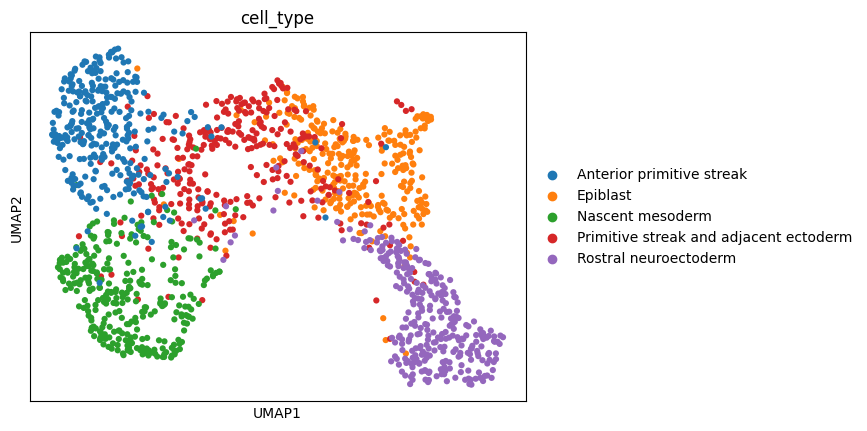

In [6]:
sc.pp.neighbors(adata_generated, use_rep='X_ce_latent', n_neighbors=30)
sc.tl.umap(adata_generated)
sc.pl.umap(adata_generated, color='cell_type')

## Generation of continuous cell state trajectories

We can iteratively generate the whole developmental trajectory of a cell type starting from the epiblast (embryonic stem cell). This process requires the user to have certain prorir knowledge of the developmental process of interest.

As an example, let's generate the trajectory from epiblast to pancreatic islet B cells. We begin by generating a population of epiblast cells.

In [7]:
generated_cells_query =  generate_cells(model_d, ['Epiblast'] * 200)

  0%|          | 0/1 [00:00<?, ?it/s]

We can search the neighbor cell types of the generated epiblast cells.

In [8]:
cts = CellTypeSearcher(adata_ref)
ct_match_df = cts.search_ref_cell_types(generated_cells_query, radius=2)
ct_match_df[:20]

,weight
Epiblast,0.135218
Primitive streak and adjacent ectoderm,0.112515
Primitive Streak,0.042408
Anterior primitive streak,0.011405
Trophectoderm,0.011397
Rostral neuroectoderm,0.011183
Inner Cell Mass,0.008133
embryonic stem cell,0.006566
Definitive endoderm,0.005233
germ cell,0.004598


Because the pancreatic islet cells are developed from the endoderm which originates from the anterior part of the primitive streak, let's choose primitive streak as our next cell type.

By interpolating the cell type embedding vectors, we can let the diffusion model to generate a continous population of cells for the cell type transition.

In [9]:
generated_cells, cond_classes = generate_transition_cells(model_d, 'Epiblast', 'Primitive Streak', 500)

  0%|          | 0/1 [00:00<?, ?it/s]

Now we have a population of primitive streak cells, using which we can search for their neighbor cell types. By iteratively repeating this process, we can reconstruct the entire trajectory.

In [10]:
generated_cells_query = generated_cells[np.array(cond_classes) == 'Primitive Streak']
ct_match_df = cts.search_ref_cell_types(generated_cells_query, radius=2)
ct_match_df[:20]

,weight
Primitive Streak,0.130541
Epiblast,0.090694
Primitive streak and adjacent ectoderm,0.078117
Nascent Mesoderm,0.033992
Emergent Mesoderm,0.029294
Anterior primitive streak,0.029005
Nascent mesoderm,0.020287
Primordial germ cells,0.018221
germ cell,0.017277
embryonic stem cell,0.012758


Let's take a shortcut here. If we already know all the intermediate cell types, we can generate the trajectory with a few lines of code.

In [11]:
traj_cell_types = ['Epiblast', 'Primitive Streak', 'Definitive endoderm', 'Gut', 
                   'Pancreatic epithelium', 'Pancreatic islets', 'type B pancreatic cell'
                   ]

generated_cells = []
cond_classes = []

for i in range(len(traj_cell_types) - 1):
    start_cell_type = traj_cell_types[i]
    end_cell_type = traj_cell_types[i + 1]
    
    local_generated_cells, local_cond_classes = generate_transition_cells(model_d, start_cell_type, end_cell_type, 500)

    for j in range(len(local_generated_cells)):
        generated_cells.append(local_generated_cells[j])
        cond_classes.append(local_cond_classes[j])

generated_cells = np.array(generated_cells)
cond_classes = np.array(cond_classes)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

The generated cells are in the latent space. We can use the SCMG decoder to reconstruct their gene expression profiles.

  0%|          | 0/6 [00:00<?, ?it/s]

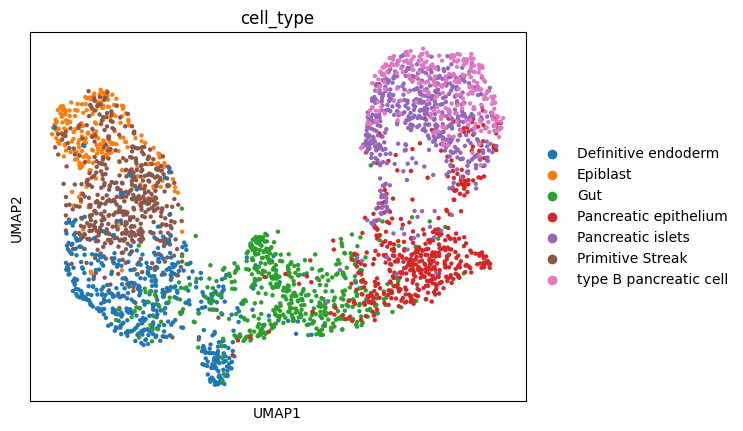

In [12]:
adata_generated = decode_cell_state_embedding(scmg_model, generated_cells, ['Qiu_Organogenesis_MM_2022:all'] * len(generated_cells))
adata_generated.obs['cell_type'] = cond_classes

# Visualize the generated cells by UMAP
sc.pp.neighbors(adata_generated, use_rep='X_ce_latent', n_neighbors=30)
sc.tl.umap(adata_generated)
sc.pl.umap(adata_generated, color='cell_type')

Using the generated continuous trajectory, we can perform pseudo time analysis.

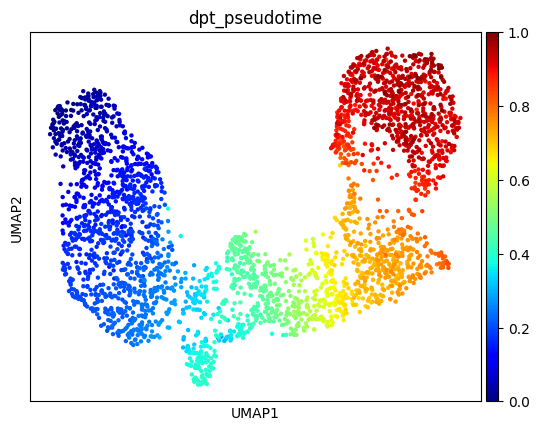

In [13]:
adata_generated.uns["iroot"] = np.flatnonzero(adata_generated.obs['cell_type'] == 'Epiblast')[0]

sc.tl.dpt(adata_generated)
adata_generated.obs['dpt_rele_rank'] = adata_generated.obs['dpt_pseudotime'].rank() / adata_generated.shape[0]

sc.pl.umap(adata_generated, color='dpt_pseudotime', cmap='jet')

Using pseudo-tiem, we can trace the gene expression changes along the developmental trajectory.

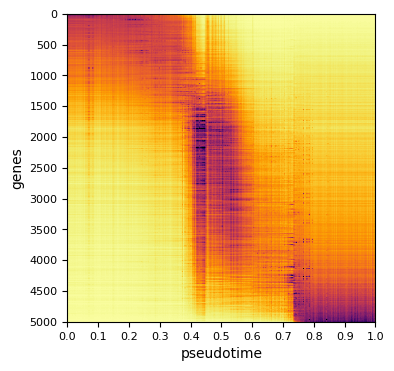

In [14]:
# Order the genes and cells by their order of expression along the trajectory
X_normalized = adata_generated.X / adata_generated.X.sum(axis=0)[None, :]
adata_generated.var['mean'] = adata_generated.X.mean(axis=0)
adata_generated.var['gene_mean_time'] = np.sum(X_normalized * adata_generated.obs['dpt_rele_rank'].values[:, None], axis=0)

cell_order = adata_generated.obs['dpt_pseudotime'].sort_values().index.values
gene_order = adata_generated.var['gene_mean_time'].sort_values().index.values
adata_ordered = adata_generated[cell_order, gene_order].copy()

adata_ordered.X = adata_ordered.X / adata_ordered.X.mean(axis=0)[None, :]

# Only plot the top highly variable genes
sc.pp.highly_variable_genes(adata_generated, n_top_genes=5000)
adata_generated.var['max'] = adata_generated.X.max(axis=0)
hv_genes = adata_generated.var_names[
    adata_generated.var['highly_variable']
]

# Plot the gene expression levels of the top highly variable genes along the trajectory
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

X = adata_ordered[:, adata_ordered.var.index.isin(hv_genes)].X.T

ax.imshow(X, vmax=5, cmap='inferno_r', aspect=X.shape[1] / X.shape[0])
ax.set_xticks(np.linspace(0, adata_ordered.shape[0], num=11), 
              [f'{x:.1f}' for x in np.linspace(0, 1, num=11)], 
              size=8)
ax.set_yticks(np.linspace(0, X.shape[0], num=11), 
              np.linspace(0, X.shape[0], num=11, dtype=int),
              size=8)

ax.set_xlabel('pseudotime')
ax.set_ylabel('genes')
plt.show()